In [65]:
# Modèle 3 : LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('data/df.csv',sep='|')
data['date'] = pd.to_datetime(data['date'])

#plt.figure(figsize=(12, 6))
#plt.plot(ts)
#plt.title('Prix journaliers du S&P500')
#plt.show()

DXY = yfinance.download('DX-Y.NYB', start='1999-01-04', end='2025-09-19')
DXY = DXY.reset_index()[['Date','Close']]
DXY.columns = ['date','DXY']
data=data.merge(DXY, on='date', how='left')

GDPM = pd.read_csv('GDP Monthly.csv',sep=',')
GDPM['date'] = pd.to_datetime(GDPM['timestamp'])
GDPM['year'] = GDPM['date'].dt.year
GDPM['month'] = GDPM['date'].dt.month
GDPM['CroissM'] = GDPM['EIA/GDPQXUS/USA'].diff()

# GDPQ = pd.read_csv('GDP Quarter.csv',sep=',')
# GDPQ['date'] = pd.to_datetime(GDPQ['timestamp'])
# GDPQ['year'] = GDPQ['date'].dt.year
# GDPQ['month'] = GDPQ['date'].dt.month

# GDPQ_full = []
# for _, row in GDPQ.iterrows():
#     for m in range(row['date'].quarter * 3 - 2, row['date'].quarter * 3 + 1):
#         GDPQ_full.append({'year': row['year'], 'month': m, 'CroissQ': row['CroissQ']})
# GDPQ_full = pd.DataFrame(GDPQ_full)


data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

data = data.merge(GDPM, on=['year', 'month'], how='left')
#data = data.merge(GDPQ, on=['year', 'month'], how='left')
#data.drop(['timestamp_x','date_y','timestamp_y', 'date'], axis=1, inplace=True)
data.drop(['timestamp','date_y','year','month'], axis=1, inplace=True)
data['DXY'].fillna(method='ffill', inplace=True)
data.rename(columns = {'date_x': 'date'}, inplace = True)
data.set_index('date', inplace=True)

data.columns = data.columns.str.lower()

[*********************100%***********************]  1 of 1 completed


In [66]:
data.head()
# data.columns
df = data.copy()

In [183]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',   # Sur quelle métrique surveiller l'amélioration
    patience=10,          # Nombre d'époques sans amélioration avant arrêt
    verbose=1,            # Affiche un message quand l'arrêt se produit
    restore_best_weights=True  # Restaure les poids correspondant à la meilleure val_loss
)




# Paramètres
seq_len = 10  # Longueur de séquence temporelle

# Normalisation
scaler = MinMaxScaler()
data = scaler.fit_transform(df)

# Création des séquences
X, y = [], []
for i in range(len(data) - seq_len):
    X.append(data[i:i+seq_len])
    y.append(data[i+seq_len, df.columns.get_loc('cible')])
X, y = np.array(X), np.array(y)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Modèle LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_len, df.shape[1])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Entraînement
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stop])

# Prédiction
predictions = model.predict(X_test)

Epoch 1/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0368 - val_loss: 0.0020
Epoch 2/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0169e-04 - val_loss: 0.0020
Epoch 3/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4183e-04 - val_loss: 0.0029
Epoch 4/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1468e-04 - val_loss: 0.0030
Epoch 5/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.9718e-05 - val_loss: 0.0017
Epoch 6/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.8205e-05 - val_loss: 0.0016
Epoch 7/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6422e-05 - val_loss: 0.0019
Epoch 8/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6540e-05 - val_loss: 0.0034
Epoch 9/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3869e-05 - val_loss: 0.0017
Epoch 10/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0986e-05 - val_loss: 0.0018
Epoch 11/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6369e-05 - val_loss: 0.0017
E

MSE: 6253.9157
MAE: 63.3294
R²: 0.9916
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Prochaine valeur prédite: 6675.1100


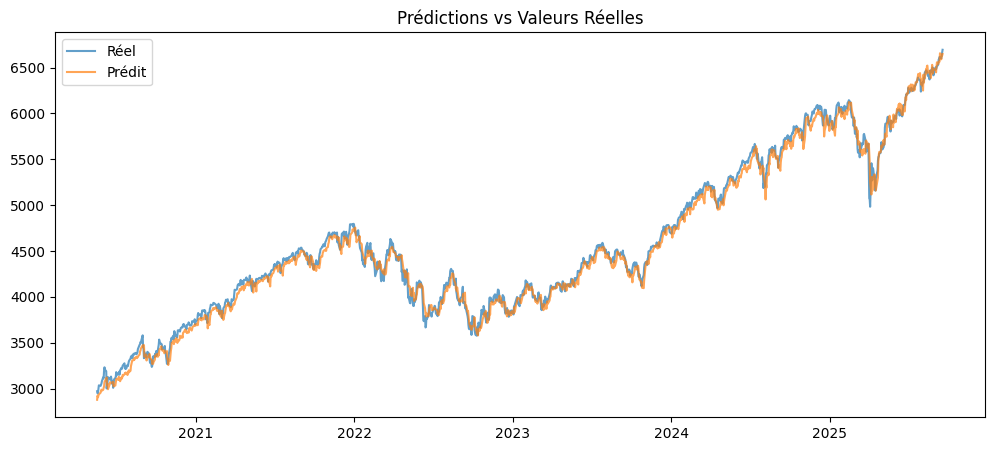

In [184]:
# Dénormaliser les prédictions
cible_idx = df.columns.get_loc('cible')
pred_denorm = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), cible_idx)), 
                                                        predictions, 
                                                        np.zeros((len(predictions), df.shape[1]-cible_idx-1))], axis=1))[:, cible_idx]
y_test_denorm = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), cible_idx)), 
                                                          y_test.reshape(-1,1), 
                                                          np.zeros((len(y_test), df.shape[1]-cible_idx-1))], axis=1))[:, cible_idx]

# Évaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print(f"MSE: {mean_squared_error(y_test_denorm, pred_denorm):.4f}")
print(f"MAE: {mean_absolute_error(y_test_denorm, pred_denorm):.4f}")
print(f"R²: {r2_score(y_test_denorm, pred_denorm):.4f}")

# Prédire le prochain point (future)
derniere_seq = data[-seq_len:].reshape(1, seq_len, df.shape[1])
next_pred = model.predict(derniere_seq)
next_pred_denorm = scaler.inverse_transform(np.concatenate([np.zeros((1, cible_idx)), 
                                                             next_pred, 
                                                             np.zeros((1, df.shape[1]-cible_idx-1))], axis=1))[0, cible_idx]
print(f"\nProchaine valeur prédite: {next_pred_denorm:.4f}")

# Visualisation (optionnel)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(df.iloc[-len(y_test_denorm):].index, y_test_denorm, label='Réel', alpha=0.7)
plt.plot(df.iloc[-len(y_test_denorm):].index, pred_denorm, label='Prédit', alpha=0.7)
plt.legend()
plt.title('Prédictions vs Valeurs Réelles')
plt.show()

In [182]:
results = pd.concat([pd.DataFrame(df.iloc[-len(y_test_denorm):].index, columns = ['date']), pd.DataFrame(pred_denorm, columns = ['pred']), pd.DataFrame(y_test_denorm, columns = ['real'])], axis=1)
results['diff'] = results['real'] - results['pred']
results

,date,pred,real,diff
0,2020-05-18,2856.409436,2971.61,115.200564
1,2020-05-19,2883.856887,2948.51,64.653113
2,2020-05-20,2869.179858,2955.45,86.270142
3,2020-05-21,2900.497369,2991.77,91.272631
4,2020-05-22,2941.657967,3036.13,94.472033
...,...,...,...,...
1337,2025-09-12,6107.359609,6606.76,499.400391
1338,2025-09-15,6188.722838,6600.35,411.627162
1339,2025-09-16,6244.117348,6631.96,387.842652
1340,2025-09-17,6240.392006,6664.36,423.967994


In [83]:
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)

scipy: 1.15.3
numpy: 2.3.1
matplotlib: 3.10.3
pandas: 2.3.0
statsmodels: 0.14.4
sklearn: 1.7.0


In [86]:
# # theano
# import theano
# print('theano: %s' % theano.__version__)
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# keras
import keras
print('keras: %s' % keras.__version__)

tensorflow: 2.20.0
keras: 3.10.0


In [108]:
pd.DataFrame(df.columns)

,0
0,close
1,volume
2,high
3,low
4,pe
5,num_daily_adv_minus_decl
6,mov_avg_20d
7,best_eps
8,dvd_sh_last
9,rsi_3d


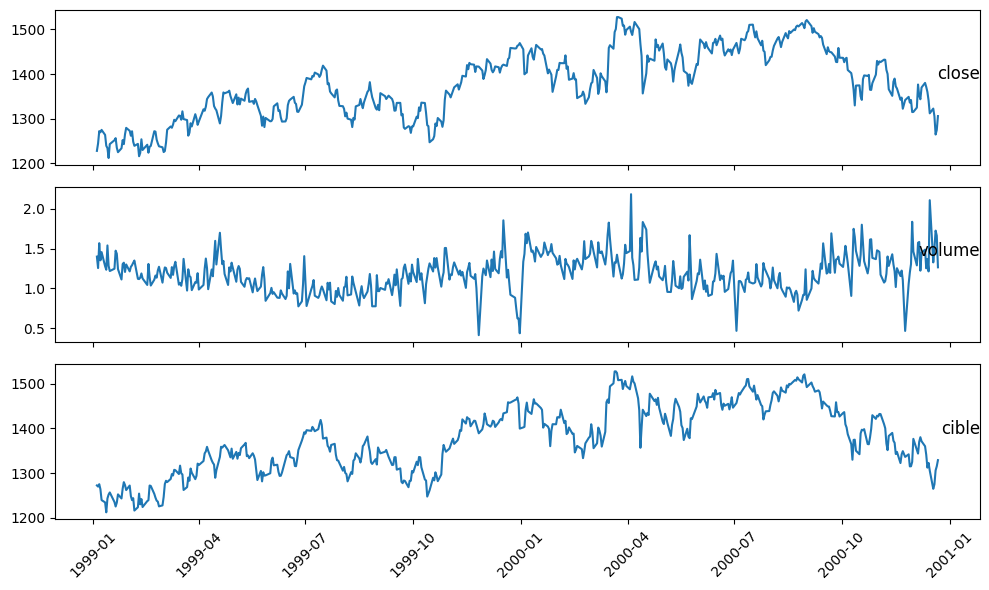

In [119]:
from pandas import read_csv
from matplotlib import pyplot as plt
# load dataset
dataset = df.iloc[:500].copy()
values = dataset.values
# specify columns to plot
groups = [0, 1, 29]
i = 1

fig, axes = plt.subplots(len(groups), 1, figsize=(10, 6), sharex=True)

for i, group in enumerate(groups):
    axes[i].plot(dataset.index, values[:, group])
    axes[i].set_title(dataset.columns[group], y=0.5, loc='right')

# rotation des ticks seulement en bas
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [143]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
from pandas import DataFrame, concat
from sklearn.preprocessing import MinMaxScaler

# version adaptée : on génère juste les X (lags), la cible est déjà dans df
def series_to_supervised_with_target(df, target_col, n_in=30, dropnan=True):
    """
    Transforme un DataFrame en problème supervisé (X,y) :
    - X : séquences des features sur n_in pas de temps
    - y : colonne cible déjà présente dans df
    """
    # Séparer features et target
    features = df.drop(columns=[target_col])
    target = df[target_col]

    n_vars = features.shape[1]
    cols, names = list(), list()

    # créer les décalages (lags) pour les features
    for i in range(n_in, 0, -1):
        cols.append(features.shift(i))
        names += [f"{col}(t-{i})" for col in features.columns]

    # concaténer toutes les features décalées
    agg = concat(cols, axis=1)

    # ajouter la cible (déjà décalée dans df)
    agg[target_col] = target.values

    # drop les NaN créés par le shift
    if dropnan:
        agg.dropna(inplace=True)

    return agg

# Exemple d'utilisation :
# On suppose que df contient déjà une colonne 'cible' = close.shift(-1)
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

reframed = series_to_supervised_with_target(scaled, target_col="cible", n_in=1)

reframed.head()


,close,volume,high,low,pe,num_daily_adv_minus_decl,mov_avg_20d,best_eps,dvd_sh_last,rsi_3d,...,close_minus_10d,close_minus_20d,close_minus_30d,close_minus_50d,close_minus_100d,close_minus_200d,dxy,eia/gdpqxus/usa,croissm,cible
date,,,,,,,,,,,,,,,,,,,,,
1999-01-05,0.092616,0.295501,0.092852,0.092902,0.768275,0.486083,0.079449,0.008081,0.023322,0.512826,...,0.723182,0.669441,0.648683,0.737443,0.615104,0.520772,0.446036,0.0,0.562692,0.098584
1999-01-06,0.095417,0.260031,0.092399,0.094416,0.784263,0.671968,0.080038,0.008081,0.032449,0.812025,...,0.738329,0.683155,0.660170,0.748071,0.615104,0.520772,0.446641,0.0,0.562692,0.099475
1999-01-07,0.100045,0.337168,0.096826,0.097221,0.810676,0.811133,0.080771,0.008081,0.176044,0.929332,...,0.766711,0.707246,0.680368,0.766781,0.615104,0.520772,0.468025,0.0,0.562692,0.097612
1999-01-08,0.099607,0.284030,0.096799,0.099391,0.808176,0.329026,0.081537,0.008081,0.048050,0.855825,...,0.754014,0.699987,0.675869,0.761562,0.615104,0.520772,0.451684,0.0,0.562692,0.093561
1999-01-11,0.100507,0.309581,0.097757,0.100093,0.813324,0.576541,0.082330,0.007759,0.000000,0.885329,...,0.754978,0.700792,0.677802,0.762493,0.615104,0.520772,0.464394,0.0,0.562692,0.092712


In [148]:
# split into train and test sets
values = reframed.values

# découpage train/test (80/20 ici, tu peux ajuster)
n_train = int(len(values) * 0.8)
train = values[:n_train, :]
test = values[n_train:, :]

# X = toutes les colonnes sauf 'cible'
# y = uniquement la colonne 'cible'
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# nombre de features (colonnes explicatives)
n_features = train_X.shape[1]

# reshape en 3D pour LSTM : [samples, timesteps, features]
# ici timesteps = 1, car tu as déjà "aplati" la fenêtre avec series_to_supervised
train_X = train_X.reshape((train_X.shape[0], 1, n_features))
test_X = test_X.reshape((test_X.shape[0], 1, n_features))

print("Train X:", train_X.shape)
print("Train y:", train_y.shape)
print("Test X:", test_X.shape)
print("Test y:", test_y.shape)


Train X: (5374, 1, 50)
Train y: (5374,)
Test X: (1344, 1, 50)
Test y: (1344,)
